In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cryptopunks/txn_history-2021-10-07.jsonl
/kaggle/input/cryptopunks/imgs/imgs/9273.png
/kaggle/input/cryptopunks/imgs/imgs/9292.png
/kaggle/input/cryptopunks/imgs/imgs/4353.png
/kaggle/input/cryptopunks/imgs/imgs/7968.png
/kaggle/input/cryptopunks/imgs/imgs/6490.png
/kaggle/input/cryptopunks/imgs/imgs/5511.png
/kaggle/input/cryptopunks/imgs/imgs/6262.png
/kaggle/input/cryptopunks/imgs/imgs/2664.png
/kaggle/input/cryptopunks/imgs/imgs/8419.png
/kaggle/input/cryptopunks/imgs/imgs/9703.png
/kaggle/input/cryptopunks/imgs/imgs/2539.png
/kaggle/input/cryptopunks/imgs/imgs/9110.png
/kaggle/input/cryptopunks/imgs/imgs/5703.png
/kaggle/input/cryptopunks/imgs/imgs/1231.png
/kaggle/input/cryptopunks/imgs/imgs/1017.png
/kaggle/input/cryptopunks/imgs/imgs/4803.png
/kaggle/input/cryptopunks/imgs/imgs/7197.png
/kaggle/input/cryptopunks/imgs/imgs/2437.png
/kaggle/input/cryptopunks/imgs/imgs/7530.png
/kaggle/input/cryptopunks/imgs/imgs/3217.png
/kaggle/input/cryptopunks/imgs/imgs/5695.png


In [2]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
opt = {'n_epochs':100,  # Number of epochs to train for
       'batch_size':64,  # Batch size
       'lr':0.0002,  # Learning Rate
       'b1':0.5,  # Adam optimizer beta 1
       'b2':0.999,  # Adam optimizer beta 2
       'latent_dim':100,  # Size of generator input dim
       'img_size':32,  # Image size to produce
       'channels':3,  # Number of channels - 1 for BW, 3 for RGB
       }


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt['img_size'] // 4
        self.l1 = nn.Sequential(nn.Linear(opt['latent_dim'], 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt['channels'], 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(opt['channels'], 16, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),

            nn.Conv2d(16, 32, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, 0.8),

            nn.Conv2d(32, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, 0.8),

            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8),

            nn.Conv2d(128, 128, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8)
        )

        # The height and width of downsampled image
        ds_size = opt['img_size'] // 2 ** 4
        self.output_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.conv_layers(img)
        out = out.view(out.shape[0], -1)
        validity = self.output_layer(out)

        return validity

In [4]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

# Loss function
adversarial_loss = torch.nn.BCELoss().to(device)

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt['lr'], betas=(opt['b1'], opt['b2']))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt['lr'], betas=(opt['b1'], opt['b2']))

print(generator)
print(discriminator)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)
Discriminator(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_sl

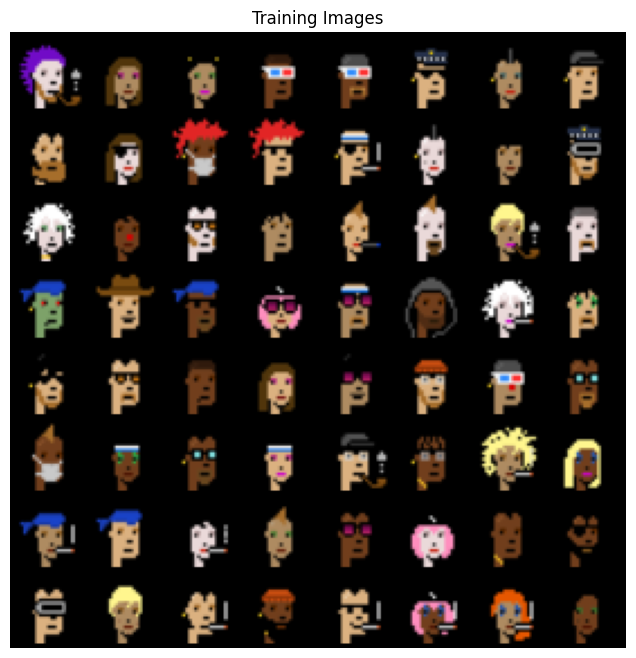

In [5]:
# Root directory for dataset
dataroot = '../input/cryptopunks/'

# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose(
                           [transforms.Resize([opt['img_size'], opt['img_size']]), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
                           ))

# Configure data loader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt['batch_size'],
    shuffle=True,
)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
# Training

# track the progress
G_losses = []
D_losses = []
for epoch in range(opt['n_epochs']):
    g_losses = []
    for i, (imgs, _) in enumerate(dataloader):
        # Adversarial ground truths
        valid = torch.Tensor(imgs.shape[0], 1).fill_(1.0).to(device)
        fake = torch.Tensor(imgs.shape[0], 1).fill_(0.0).to(device)
        # Configure input
        real_imgs = imgs.to(device)

        # ---------------------
        #  Train Generator
        optimizer_G.zero_grad()
        # Sample noise as generator input
        z = torch.Tensor(np.random.normal(0, 1, (imgs.shape[0], opt['latent_dim']))).to(device)
        # Generate a batch of images
        gen_imgs = generator(z)
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        optimizer_D.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if (i+1)%100==0:
          print(
              "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
              % (epoch, opt['n_epochs'], i, len(dataloader), d_loss.item(), np.mean(g_losses))
          )
          
          # total losses
          G_losses.append(np.mean(g_losses))
          D_losses.append(d_loss.item())
        
          g_losses = []
        else:
          g_losses.append(g_loss.item())

[Epoch 0/100] [Batch 99/157] [D loss: 0.735679] [G loss: 1.021959]
[Epoch 1/100] [Batch 99/157] [D loss: 0.293534] [G loss: 1.094385]
[Epoch 2/100] [Batch 99/157] [D loss: 0.666513] [G loss: 1.101687]
[Epoch 3/100] [Batch 99/157] [D loss: 0.552898] [G loss: 1.201653]
[Epoch 4/100] [Batch 99/157] [D loss: 0.632214] [G loss: 1.190900]
[Epoch 5/100] [Batch 99/157] [D loss: 0.330096] [G loss: 1.181064]
[Epoch 6/100] [Batch 99/157] [D loss: 0.420525] [G loss: 1.171291]
[Epoch 7/100] [Batch 99/157] [D loss: 0.385412] [G loss: 1.255704]
[Epoch 8/100] [Batch 99/157] [D loss: 0.365102] [G loss: 1.296955]
[Epoch 9/100] [Batch 99/157] [D loss: 0.301838] [G loss: 1.303400]
[Epoch 10/100] [Batch 99/157] [D loss: 0.124310] [G loss: 1.285343]
[Epoch 11/100] [Batch 99/157] [D loss: 0.544709] [G loss: 1.404900]
[Epoch 12/100] [Batch 99/157] [D loss: 0.581257] [G loss: 1.354766]
[Epoch 13/100] [Batch 99/157] [D loss: 0.217755] [G loss: 1.594621]
[Epoch 14/100] [Batch 99/157] [D loss: 0.334238] [G loss: 

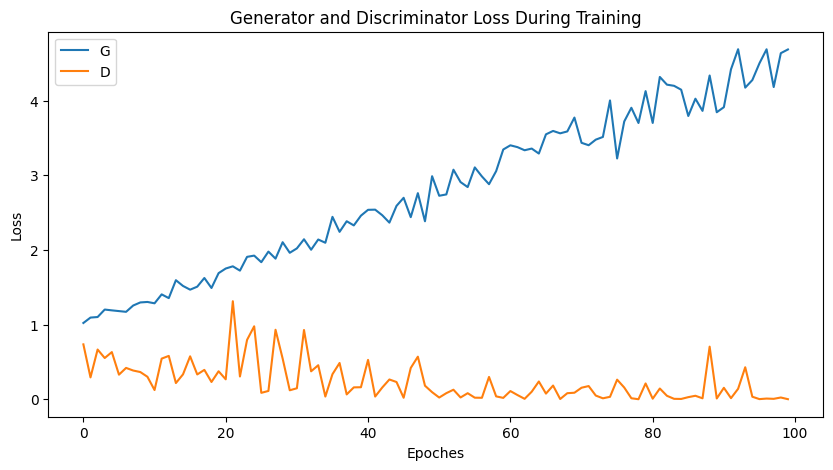

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.legend()
plt.show()

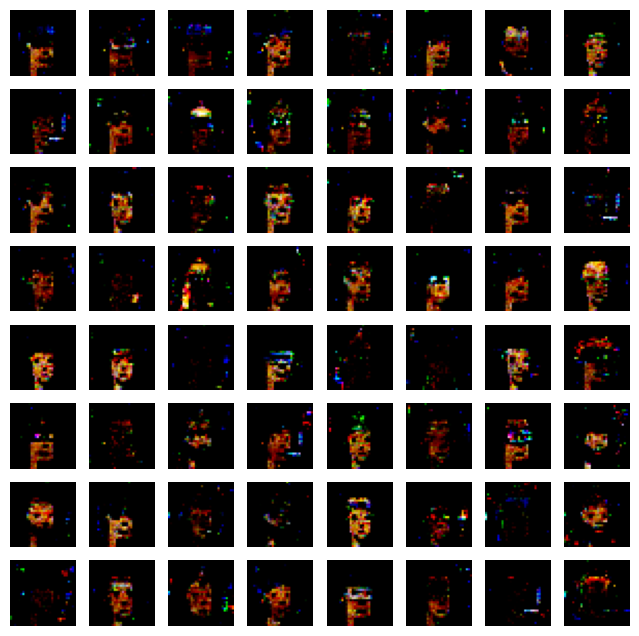

In [10]:
# Number of rows and columns in the grid
num_rows, num_cols = 8, 8
num_images = num_rows * num_cols

# Generate and plot images
plt.figure(figsize=(8, 8))

for i in range(num_images):
    # Generate new RGB image
    z = torch.Tensor(np.random.normal(0, 1, (1, opt['latent_dim']))).to(device)
    gen_img = generator(z).detach().cpu().numpy().squeeze().transpose(1, 2, 0)

    # Plot the generated RGB image
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(gen_img)
    plt.axis('off')

plt.show()